# Models and Data: Calibration, Moment Matching, and OLS

In this notebook we combine the macro models you have already seen with simple data targets.

**Aim.** See how we can choose parameters so that model predictions are close to data:

- **Calibration** with the Solow growth model.
- **Moment matching** with a simple consumer problem.
- **OLS** with a small AS–AD / Phillips-curve style model.

We re-use the style of the earlier notebooks: `par` dictionaries for parameters, and plots.


**Table of contents**<a id='toc0_'></a>    
- 1. [Idea: model + data + moments](#toc1_)    
- 2. [Calibration with the Solow model](#toc2_)    
  - 2.1. [Data targets and calibration strategy](#toc2_1_)    
  - 2.2. [Steady-state diagram with calibrated parameters](#toc2_2_)    
- 3. [Moment matching with a consumer problem](#toc3_)    
  - 3.1. [What we do here](#toc3_1_)    
  - 3.2. [Build a tiny (simulated) data set](#toc3_2_)    
  - 3.3. [Define moments and loss function](#toc3_3_)    
  - 3.4. [Visual check of the fit](#toc3_4_)    
- 4. [Estimating parameters of a simple AS–AD model via OLS](#toc4_)    
  - 4.1. [Simulate data from the Phillips curve](#toc4_1_)    
  - 4.2. [OLS estimation](#toc4_2_)    
  - 4.3. [Calibration and Business Cycle Moments](#toc4_3_)    
  - 4.4. [Discussion](#toc4_4_)    
- 5. [Wrap-up](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Idea: model + data + moments](#toc0_)

The common story in all sections is:

1. We pick some **model parameters** $\theta$ (for example $\alpha$, $s$, $\delta$, $\beta$, $\kappa$).
2. We run the **model** and get simulated outcomes (for example $k_t$, $y_t$, $\pi_t$).
3. From the model outcomes we compute simple **summary statistics** (called *moments*):
   - means,
   - variances,
   - covariances, etc.
4. We compare the model moments to the **data moments** and change specific parameters until they are close.

We can draw this as a pipeline:

$$
\theta \;\Rightarrow\; \text{model} \;\Rightarrow\; \text{simulated data} \;\Rightarrow\; m_{\text{model}}(\theta)
\quad\text{and we want}\quad
m_{\text{model}}(\theta) \approx m_{\text{data}}.
$$

Different methods (calibration, moment matching) are just **different ways to choose $\theta$**.


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from math import isfinite
from scipy import optimize

plt.rcParams.update({'axes.grid': True,
                     'grid.color': '0.8',
                     'grid.linestyle': '--',
                     'font.size': 13})


## 2. <a id='toc2_'></a>[Calibration with the Solow model](#toc0_)

We start with the familiar **Solow model without growth** (per worker):

- Production: $y = f(k) = k^{\alpha}$
- Capital accumulation:
  $$ k_{t+1} = s f(k_t) + (1 - \delta) k_t $$

Parameters:

- $\alpha$ = capital share.
- $s$ = savings rate.
- $\delta$ = depreciation rate.

In steady state the capital stock is constant, $k_{t+1} = k_t = k^{\star}$, which gives the textbook formula

$$
k^{\star} = \left( \frac{s}{\delta} \right)^{\tfrac{1}{1-\alpha}}.
$$

The **real interest rate** in this simple model is

$$
r^{\text{model}} = f'(k^{\star}) - \delta = \alpha (k^{\star})^{\alpha - 1} - \delta.
$$

We will **calibrate** $s$ and $\delta$ so that the model matches these data moments:

- Investment share $I/Y \approx 0.20$.
- Real interest rate $r \approx 0.04$.
- Danish share of capital in production, $\alpha$.


In [50]:
# === Solow model functions ===

def f(k, alpha):
    """Cobb–Douglas production function y = k^alpha."""
    return np.power(k, alpha)

def fprime(k, alpha):
    """Marginal product of capital f'(k)."""
    return alpha * np.power(k, alpha - 1)

def k_star(alpha, s, delta):
    """Closed-form Solow steady state (no growth)."""
    return np.power(s / delta, 1.0 / (1.0 - alpha))

def r_steady(alpha, s, delta):
    """Steady state real interest rate implied by the Solow model."""
    k_ss = k_star(alpha, s, delta)
    return fprime(k_ss, alpha) - delta


### 2.1. <a id='toc2_1_'></a>[Data targets and calibration strategy](#toc0_)

We feed in very simple "data":

- Capital share $\alpha$ = We load data from a csv (from DST) and calibrate it to the actual labor share in Danish data (measured as compensation of employees / GDP (at market prices) in percent; https://www.dst.dk/en/Statistik/temaer/SDG/globale-verdensmaal/10-mindre-ulighed/delmaal-04/indikator-1).
- Investment share $I/Y = 0.20$.
- Long-run real interest rate $r = 0.04$.

In the Solow model without growth we have $I/Y = s$, so we can set

$$ s = 0.20. $$

The only unknown is then $\delta$. We choose $\delta$ so that

$$
r^{\text{model}}(\delta) = 0.04.
$$

We will use a **root finder** (as in the root-finding lecture 7) to solve

$$
r^{\text{model}}(\delta) - 0.04 = 0.
$$


In [51]:
import pandas as pd

# 1) Read the CSV file from Statistics Denmark
fn = "labor_share_dk.csv"   # adjust the filename / path as needed

# The CSVs are usually semicolon-separated 
df = pd.read_csv(fn, sep=";")

# Inspect once to find the relevant columns
print(df.columns)
print(df.head())


Index(['OMR20', 'TID', 'INDHOLD'], dtype='object')
   OMR20   TID  INDHOLD
0  Total  2010     52.6
1  Total  2011     52.3
2  Total  2012     51.6
3  Total  2013     51.4
4  Total  2014     51.3


In [52]:
year_col  = "TID"      # this is our year column
value_col = "INDHOLD"     # this columns contains the labour share values

# 2) Restrict to a calibration window, for example 1995–2019
mask = (df[year_col] >= 1995) & (df[year_col] <= 2019)
df_calib = df.loc[mask].copy()

# 3) Convert from percent to fraction if needed
df_calib["labour_share"] = df_calib[value_col] / 100.0

# 4) Use the average labour share over the window as your target
labour_share_target = df_calib["labour_share"].mean()
print("Average labour share (1995–2019) =", labour_share_target)

# 5) Calibrate alpha from this target and plug into your Solow code
alpha_data = 1.0 - labour_share_target
print("Calibrated alpha from Danish labour share =", alpha_data)


Average labour share (1995–2019) = 0.5165999999999998
Calibrated alpha from Danish labour share = 0.48340000000000016


In [71]:
# === 1.1 Calibration of s and delta ===

# alpha_data = set above based on the data
IY_data    = 0.20       # investment share
r_data     = 0.04       # real interest rate

# In the simple Solow model I/Y = s
s_calib = IY_data


## We define a function for the difference between model and data r to use in the optimization 
def r_gap(delta):
    """Difference between model r and data r for a given delta."""
    return r_steady(alpha_data, s_calib, delta) - r_data


# --- 1) Root-finding with SciPy --------------------------------------------
# We look for delta between 1% and 20% per year
sol_root = optimize.root_scalar(r_gap, bracket=[0.01, 0.20])
delta_root = sol_root.root

# --- 2) Simple brute-force grid search -------------------------------------
delta_grid = np.linspace(0.01, 0.20, 200)
vals = np.array([abs(r_gap(d)) for d in delta_grid])
idx_min = np.argmin(vals)
delta_grid_best = delta_grid[idx_min]

# --- 3) Compute steady states for both versions ----------------------------
k_ss_root   = k_star(alpha_data, s_calib, delta_root)
r_model_root = r_steady(alpha_data, s_calib, delta_root)

k_ss_grid    = k_star(alpha_data, s_calib, delta_grid_best)
r_model_grid = r_steady(alpha_data, s_calib, delta_grid_best)

# --- 4) Print comparison ---------------------------------------------------
print("Calibration using root_scalar:")
print(f"  s (fixed)                     = {s_calib:5.3f}")
print(f"  delta_root                    = {delta_root:5.3f}")
print(f"  k*                            = {k_ss_root:5.3f}")
print(f"  r_model                       = {r_model_root:5.3f}")
print()
print("Calibration using grid search:")
print(f"  delta_grid_best               = {delta_grid_best:5.3f}")
print(f"  k*                            = {k_ss_grid:5.3f}")
print(f"  r_model                       = {r_model_grid:5.3f}")
print()
print(f"Difference in delta (root - grid) = {abs(delta_root - delta_grid_best):.3e}")
print(f"Difference in r (root - grid)     = {abs(r_model_root - r_model_grid):.3e}")


Calibration using root_scalar:
  s (fixed)                     = 0.200
  delta_root                    = 0.028
  k*                            = 44.262
  r_model                       = 0.040

Calibration using grid search:
  delta_grid_best               = 0.028
  k*                            = 44.530
  r_model                       = 0.040

Difference in delta (root - grid) = 8.795e-05
Difference in r (root - grid)     = 1.246e-04


### 2.2. <a id='toc2_2_'></a>[Steady-state diagram with calibrated parameters](#toc0_)

To build intuition we plot:

- $s f(k)$ = investment per worker (using our calibrated $s$).
- $\delta k$ = break-even investment (using our calibrated $\delta$).

Their intersection is the steady state $k^{\star}$.


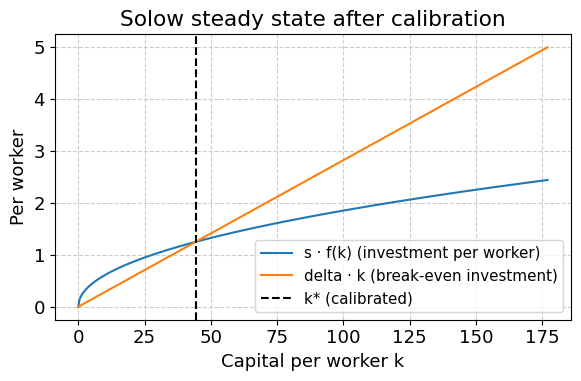

In [54]:
# Steady-state diagram using the calibrated values (root_scalar version)

k_grid = np.linspace(1e-6, max(4*k_ss_root, 4.0), 400)
y_grid = f(k_grid, alpha_data)
invest = s_calib * y_grid
depr   = delta_root * k_grid

plt.figure(figsize=(6,4))
plt.plot(k_grid, invest, label='s · f(k) (investment per worker)')
plt.plot(k_grid, depr,   label='delta · k (break-even investment)')
plt.axvline(k_ss_root, color='black', linestyle='--', label='k* (calibrated)')
plt.xlabel('Capital per worker k')
plt.ylabel('Per worker')
plt.title('Solow steady state after calibration')
plt.legend(fontsize='small')  # 

plt.tight_layout()
plt.show()


## 3. <a id='toc3_'></a>[Moment matching with a consumer problem](#toc0_)

Next we use the **two-good consumer problem** from the optimization lecture 7.

Preferences are Cobb–Douglas:

$$
u(x_1, x_2) = x_1^{\alpha} x_2^{1-\alpha},
$$

with budget constraint

$$
p_1 x_1 + p_2 x_2 = I.
$$

In this model the optimal demand is

$$
x_1^{\star} = \frac{\alpha I}{p_1}, \qquad
x_2^{\star} = \frac{(1-\alpha) I}{p_2}.
$$

For any given taste parameter $\alpha$, prices, and income, the model tells us exactly what the consumer _should_ choose. So $\alpha$ governs how much of the budget goes to good 1 vs good 2. Higher $\alpha$ means a larger budget share for good 1.


### 3.1. <a id='toc3_1_'></a>[What we do here](#toc0_)

We pretend we have data from $N$ households:

- each household faces prices $(p_1, p_2)$ and income $I$,
- we observe their choice $x_{1,i}^{\text{data}}$.
- we do _not know_ their true $\alpha$. 
- we want to choose an $\alpha$ that makes the model's prediction consistent with the data.

We then choose the preference parameter $\alpha$ to make the model choices $x_{1,i}^{\star}(\alpha)$ close to the data choices in **mean squared error**:

$$
L(\alpha) = \frac{1}{N} \sum_{i=1}^N \big( x_{1,i}^{\star}(\alpha) - x_{1,i}^{\text{data}} \big)^2.
$$

Minimizing $L(\alpha)$ is a simple example of **moment matching** / **non-linear least squares**.


In [55]:
def demand_cobb_douglas(alpha, p1, p2, I):
    """Closed-form demand for good 1 and 2 with Cobb–Douglas utility."""
    x1 = alpha * I / p1
    x2 = (1 - alpha) * I / p2
    return x1, x2


### 3.2. <a id='toc3_2_'></a>[Build a tiny (simulated) data set](#toc0_)

In a real application we would load data from a file.

Here we **simulate** data so that we know the true parameter and can check if our method recovers it, i.e. we create our own artificial data set.

Steps:

1. Fix a true Cobb–Douglas parameter $\alpha^{\text{true}}$.
2. Draw some incomes $I_i$ and different prices $p_{1,i}$, $p_{2,i}$.
3. Compute the model-optimal $x_{1,i}^{\star}$.
4. Add a little noise so that the data is not perfectly on the model.


In [77]:
# Set random seed for reproducibility       
rng = np.random.default_rng(0)


# Simulate "data" from the model
N          = 500
alpha_true = 0.30

p1_data = rng.uniform(1.0, 3.0, size=N)
p2_data = rng.uniform(1.0, 3.0, size=N)
I_data  = rng.uniform(10.0, 50.0, size=N)

# Model-implied optimal choice + a bit of measurement noise
x1_true = alpha_true * I_data / p1_data
eps     = rng.normal(0.0, 0.2, size=N) # we draw small normal noise
x1_data = np.maximum(x1_true + eps, 1e-6)   # observed x1_i^data, here we add a small random noise t

### 3.3. <a id='toc3_3_'></a>[Define moments and loss function](#toc0_)

Our **moment condition** is that model and data choices for $x_1$ should be close *on average*.

We use the squared error loss

$$
L(\alpha) = \frac{1}{N} \sum_{i=1}^N \big( x_{1,i}^{\star}(\alpha) - x_{1,i}^{\text{data}} \big)^2,
$$

and choose

$$
\hat \alpha = \arg\min_{\alpha \in (0,1)} L(\alpha).
$$


In [78]:
# Given a candidate alpha, compute model choices and the loss function L(alpha)
def x1_star(alpha, p1, I):
    return alpha * I / p1

def loss(alpha):
    x1_model = x1_star(alpha, p1_data, I_data)
    return np.mean((x1_model - x1_data)**2)   # simulated method of moments / NLS

# Calibrate alpha by minimizing L(alpha) over (0,1)
res = optimize.minimize_scalar(loss, bounds=(0.01, 0.99), method="bounded")
alpha_hat = res.x

print(f"True alpha          = {alpha_true:5.3f}")
print(f"Estimated alpha     = {alpha_hat:5.3f}")
print(f"Minimized loss L    = {res.fun:8.4e}")

True alpha          = 0.300
Estimated alpha     = 0.300
Minimized loss L    = 4.1699e-02


We can visualize the loss for a range of alpha values:

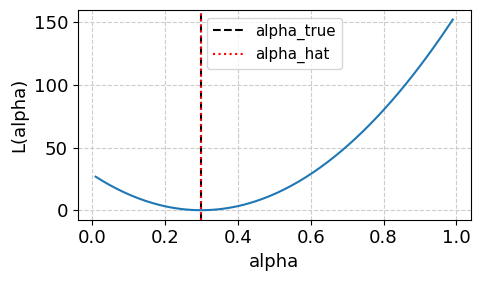

In [79]:
alphagrid = np.linspace(0.01, 0.99, 200)
lossgrid  = np.array([loss(a) for a in alphagrid]) # we evaluate the loss function on the grid

plt.figure(figsize=(5,3))
plt.plot(alphagrid, lossgrid)
plt.axvline(alpha_true, color="black", linestyle="--", label="alpha_true")
plt.axvline(alpha_hat,  color="red",   linestyle=":",  label="alpha_hat")
plt.xlabel("alpha")
plt.ylabel("L(alpha)")
plt.legend(fontsize="small")
plt.tight_layout()
plt.show()


### 3.4. <a id='toc3_4_'></a>[Visual check of the fit](#toc0_)

We can check how the model with $\hat \alpha$ fits the observed choices.


R^2 (x1_data on x1_fit) = 0.994


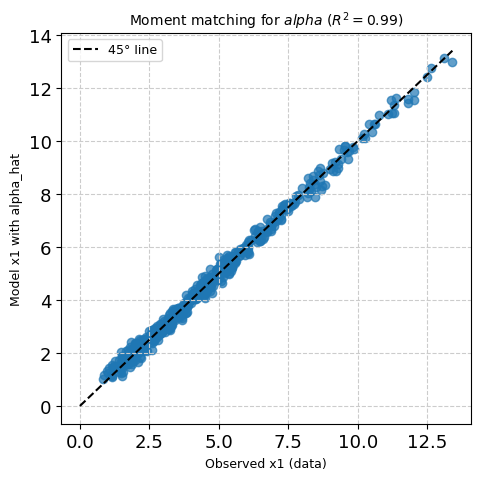

In [80]:
from functions_asad import compute_r2  # load in function to compute R^2


# fitted values from the calibrated model
x1_fit, _ = demand_cobb_douglas(alpha_hat, p1_data, p2_data, I_data)

# --- R^2: regression of x1_data on x1_fit with intercept --------------------
R2, a_hat, b_hat = compute_r2(x1_data, x1_fit)

print(f"R^2 (x1_data on x1_fit) = {R2:.3f}")

# --- fit plot --------------------------------------------------------------
plt.figure(figsize=(5,5))
plt.scatter(x1_data, x1_fit, alpha=0.7)
max_val = max(np.max(x1_data), np.max(x1_fit))
plt.plot([0, max_val], [0, max_val], 'k--', label='45° line')
plt.xlabel('Observed x1 (data)', fontsize=9)
plt.ylabel('Model x1 with alpha_hat', fontsize=9)
plt.title(rf'Moment matching for $alpha$ ($R^2 = {R2:.2f}$)', fontsize=10)
plt.legend(fontsize='x-small')
plt.tight_layout()
plt.show()

**Interpretation.**

- We start from data: for each household $i$ we observe $(p_{1,i}, p_{2,i}, I_i, x_{1,i}^{\text{data}})$.
- For any given parameter $\alpha$, the model tells us what this household *would* choose:
  $x_{1,i}^{\star}(\alpha) = \alpha I_i / p_{1,i}$.
- The loss $L(\alpha)$ measures how far model and data are apart on average:
  small $L(\alpha)$ means model choices are close to observed choices.

- Choosing $\hat\alpha$ by minimizing $L(\alpha)$ means:
  > pick the parameter value for which the model “fits the data” best in mean squared error.

- The only math we used is:
  - write down a loss $L(\alpha)$,
  - ask the computer to **minimize** it.

This is exactly the idea of **moment matching** / **simulated method of moments**:
we pick parameters so that model-generated objects (here $x_1^\star$) match data objects (here $x_1^{\text{data}}$) as closely as possible.  
It is very close to how we would calibrate a Cobb–Douglas parameter in a simple Walras equilibrium model.


## 4. <a id='toc4_'></a>[Estimating parameters of a simple AS–AD model via OLS](#toc0_)

We now move to a very simple Phillips curve

$$
\pi_t = \beta \pi_{t-1} + \kappa x_t + u_t,
$$

where $\pi_t$ is inflation, $x_t$ is the output gap from the AS–AD part of the lecture, and $u_t$ is an error term.

We will:

1. **Simulate** artificial time series $(\pi_t, x_t)$ for given "true" parameters $(\beta_{\text{true}},\kappa_{\text{true}})$  
2. **Estimate** $(\beta,\kappa)$ by OLS  
3. **Compute Business Cycle Moments** and adjust the std of demand and supply shocks.



### 4.1. <a id='toc4_1_'></a>[Simulate data from the Phillips curve](#toc0_)

We choose "true" parameters and generate artificial time series for the output gap and inflation.


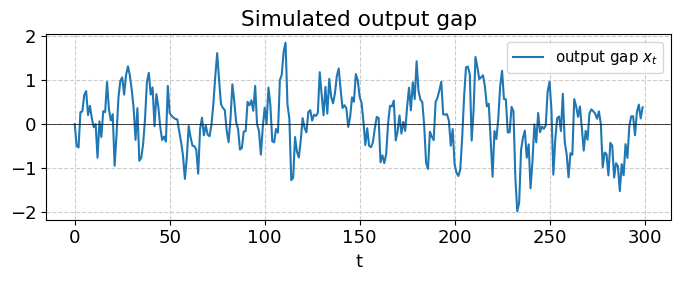

In [86]:
def simulate_phillips(T=300, beta_true=0.6, kappa_true=0.3, seed=0):
    """
    Simulate output gap x_t and inflation pi_t from a simple Phillips curve:
        x_t  : AR(1) around 0
        pi_t : pi_t = beta_true*pi_{t-1} + kappa_true*x_t + u_t
    """

    rng = np.random.default_rng(seed)
    # Output gap: AR(1) process
    x = np.zeros(T)
    for t in range(1, T):
        x[t] = 0.7 * x[t-1] + rng.normal(0.0, 0.5) # AR(1) with rho=0.7

    # Inflation
    pi = np.zeros(T)
    pi[0] = 0.02  # 2 percent initial inflation
    for t in range(1, T):
        u_t = rng.normal(0.0, 0.005) # error term to inflation
        pi[t] = beta_true * pi[t-1] + kappa_true * x[t] + u_t # philipps curve

    return pi, x

# simulate "data"
beta_true = 0.6
kappa_true = 0.3
pi, x_gap = simulate_phillips(T=300, beta_true=beta_true, kappa_true=kappa_true, seed=123)

plt.figure(figsize=(7,3))
plt.plot(x_gap, label='output gap $x_t$')
plt.axhline(0.0, color='k', linewidth=0.5)
plt.xlabel('t')
plt.title('Simulated output gap')
plt.legend(fontsize='small')
plt.tight_layout()
plt.show()

### 4.2. <a id='toc4_2_'></a>[OLS estimation](#toc0_)

We now estimate the equation

$$
\pi_t = \beta \pi_{t-1} + \kappa x_t + u_t
$$

by OLS.

We drop the first observation to form lags.


In [87]:
# Drop first observation to create lagged variables
y = pi[1:]              # dependent variable: pi_t
pi_lag = pi[:-1]        # pi_{t-1}
x_t = x_gap[1:]         # x_t

T = len(y)

# Design matrix: constant, pi_{t-1}, x_t
X = np.vstack([np.ones(T), pi_lag, x_t]).T # this creates a T x 3 matrix including intercept, pi_lag, and x_t. Note that np.vstack stacks the three arrays, then transposes it (.T))

# OLS via normal equations
theta_ols, _, _, _ = np.linalg.lstsq(X, y, rcond=None) # this calls the least squares solver, theta_OLS contains the estimated parameters
intercept_hat, beta_hat, kappa_hat = theta_ols # we read out the estimated parameters

print("True parameters:")
print(f"  beta_true  = {beta_true:6.3f}")
print(f"  kappa_true = {kappa_true:6.3f}")
print()
print("OLS estimates:")
print(f"  beta_hat   = {beta_hat:6.3f}")
print(f"  kappa_hat  = {kappa_hat:6.3f}")


True parameters:
  beta_true  =  0.600
  kappa_true =  0.300

OLS estimates:
  beta_hat   =  0.598
  kappa_hat  =  0.301


We can also compute and inspect the residuals and compare the residual variance to the true innovation variance:

In [ ]:
# residuals from the correctly specified regression
y_hat = X @ theta_ols # note that @ is matrix multiplication; we compute the fitted values 
u_hat = y - y_hat # residuals

print(f"Mean of residuals = {np.mean(u_hat): .4e}")
print(f"Std of residuals  = {np.std(u_hat, ddof=1): .4f}")

# compare to true innovation std in simulate_phillips (sigma_u = 0.005)
sigma_u_true = 0.005
print(f"True sigma_u (from DGP) = {sigma_u_true: .4f}")


Mean of residuals = -5.0127e-18
Std of residuals  =  0.0052
True sigma_u (from DGP) =  0.0050


### 4.3. <a id='toc4_3_'></a>[Calibration and Business Cycle Moments](#toc0_)

In this section, we explore whether the simple AS–AD model can reproduce
key U.S. business-cycle statistics.  
We’ll use U.S. quarterly data to compute target moments and compare them with
moments generated by the calibrated AS–AD model.

**Learning goal:** understand how far a highly stylized model can go in matching real-world fluctuations and why richer models are needed for quantitative work.


In [63]:
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter

# ----------------------------
# 1) Load real GDP (GDPC1, quarterly)
# ----------------------------

series_id_gdp = "GDPC1"
url_gdp = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id_gdp}"

gdp_raw = pd.read_csv(url_gdp, na_values=".")

# Assume first column is date, second is value, verify later
date_col_gdp, value_col_gdp = gdp_raw.columns[:2]

gdp = gdp_raw[[date_col_gdp, value_col_gdp]].copy()
gdp[date_col_gdp] = pd.to_datetime(gdp[date_col_gdp])
gdp[value_col_gdp] = gdp[value_col_gdp].astype(float)
gdp.set_index(date_col_gdp, inplace=True)
gdp.rename(columns={value_col_gdp: "GDPC1"}, inplace=True)

print("Real GDP (quarterly) head:")
print(gdp.head(), "\n")

# ----------------------------
# 2) Load CPI (CPIAUCSL, monthly)
# ----------------------------

series_id_cpi = "CPIAUCSL"
url_cpi = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id_cpi}"

cpi_raw = pd.read_csv(url_cpi, na_values=".")

date_col_cpi, value_col_cpi = cpi_raw.columns[:2]

cpi = cpi_raw[[date_col_cpi, value_col_cpi]].copy()
cpi[date_col_cpi] = pd.to_datetime(cpi[date_col_cpi])
cpi[value_col_cpi] = cpi[value_col_cpi].astype(float)
cpi.set_index(date_col_cpi, inplace=True)
cpi.rename(columns={value_col_cpi: "CPIAUCSL"}, inplace=True)

print("CPI (monthly) head:")
print(cpi.head(), "\n")

# ----------------------------
# 3) Convert CPI to quarterly (quarter start) and merge with GDP
# ----------------------------

# Quarterly CPI: quarter-start average so dates align with GDPC1
# (e.g. 1947-01-01, 1947-04-01, ...)
cpi_q = cpi.resample("QS").mean()

us_q = gdp.join(cpi_q, how="inner")

print("Merged quarterly data (gdp + cpi_q) head:")
print(us_q.head(), "\n")

# ----------------------------
# 4) Compute quarterly annualized CPI inflation and log output
# ----------------------------

# Quarterly annualized CPI inflation (approx 400 × quarterly rate)
us_q["inflation_cpi_ann"] = 400 * np.log(us_q["CPIAUCSL"]).diff()

# Log real GDP
us_q["log_y"] = np.log(us_q["GDPC1"])

# Drop first observation (NaN from diff) and any other missing values
us_bc = us_q.dropna()

print("Business-cycle sample head:")
print(us_bc.head())
print("\nBusiness-cycle sample tail:")
print(us_bc.tail(), "\n")

# ----------------------------
# 5) Great Moderation sample (from 1984Q1)
# ----------------------------

us_80s = us_bc[us_bc.index >= "1984-01-01"].copy()

# ----------------------------
# 6) HP filter on log output, construct gap in percent. Note: A HP-Filter allows us to separate a trend component from a cyclical component in a time series.
# ----------------------------
gap_cycle, gap_trend = hpfilter(us_80s["log_y"], lamb=1600)
gap_cycle = gap_cycle - gap_cycle.mean()  # mean zero

# log output gap
us_80s["y_gap"] = gap_cycle

# Convert to percent output gap (for calibration)
us_80s["gap_percent"] = 100 * gap_cycle


# ----------------------------
# 7) Target moments: std of inflation and output gap
# ----------------------------

infl_std_data = us_80s["inflation_cpi_ann"].std()
gap_std_data  = us_80s["gap_percent"].std()

# Pack data moments into a vector for calibration
mom_data = np.array([infl_std_data, gap_std_data])

print(f"Std of annualized CPI inflation (data, 1984+): {infl_std_data:.4f}")
print(f"Std of output gap in percent (data, 1984+):   {gap_std_data:.4f}")


Real GDP (quarterly) head:
                     GDPC1
observation_date          
1947-01-01        2182.681
1947-04-01        2176.892
1947-07-01        2172.432
1947-10-01        2206.452
1948-01-01        2239.682 

CPI (monthly) head:
                  CPIAUCSL
observation_date          
1947-01-01           21.48
1947-02-01           21.62
1947-03-01           22.00
1947-04-01           22.00
1947-05-01           21.95 

Merged quarterly data (gdp + cpi_q) head:
                     GDPC1   CPIAUCSL
observation_date                     
1947-01-01        2182.681  21.700000
1947-04-01        2176.892  22.010000
1947-07-01        2172.432  22.490000
1947-10-01        2206.452  23.126667
1948-01-01        2239.682  23.616667 

Business-cycle sample head:
                     GDPC1   CPIAUCSL  inflation_cpi_ann     log_y
observation_date                                                  
1947-04-01        2176.892  22.010000           5.673854  7.685653
1947-07-01        2172.432  22.4

In [64]:
def compute_moments(infl, gap):
    # ddof=1 to match pandas .std()
    infl_std = np.std(np.asarray(infl, dtype=float), ddof=1)
    gap_std  = np.std(np.asarray(gap,  dtype=float), ddof=1)
    return np.array([infl_std, gap_std])


In [ ]:
from functions_asad import par, make_shocks, simulate_with_rule_grid    

# inputs: std of demand shocks innovation; stds of supply shock innovation, T=length of simulation, burn=initial observations to throw away, seed= random seed.

def simulate_asad_for_calibration(sigma_x, sigma_c, T=2000, burn=200, seed=0):
    assert T > burn

    p_cal = par.copy() # we make a copy to not overwrite the original parameters
    p_cal["sigma_x"] = float(sigma_x) # we overwrite the shock stds with the values passed to the function  
    p_cal["sigma_c"] = float(sigma_c)

    v, s = make_shocks(T, p_cal, seed=seed) # generate shocks using our function from Lecture 11

    # simulate the model with the given shocks and parameters
    y_sim, pi_sim = simulate_with_rule_grid(
        a1=p_cal["a1"],
        a2=p_cal["a2"],
        v=v,
        s=s,
        p=p_cal
    )

    # discard initial burn-in period
    y_sim = np.asarray(y_sim[burn:], dtype=float)
    pi_sim = np.asarray(pi_sim[burn:], dtype=float)

    # model inflation: quarterly decimal to annualized percent
    pi_sim_ann = 400.0 * pi_sim

    # model output gap: y_sim is already a gap, just center it
    gap_sim = y_sim - y_sim.mean()

    return pi_sim_ann, gap_sim


In [ ]:
# We define the loss function for calibration, which computes the distance between model and data moments
# input : theta = [sigma_x, sigma_c] (=2 element vector)    
def loss(theta):
    """
    Moment-matching loss for theta = [sigma_x, sigma_c].
    We match std(infl) and std(output gap).
    """
    sigma_x, sigma_c = theta
    # impose positivity inside loss as a simple guard
    if sigma_x <= 0 or sigma_c <= 0:
        return 1e9

    # simulate model with given shock stds
    pi_sim, gap_sim = simulate_asad_for_calibration(sigma_x, sigma_c, T=3000, burn=300, seed=1)
    # we compute the implied model moments    
    mom_model = compute_moments(pi_sim, gap_sim)
    # compute distance to data moments
    diff = mom_model - mom_data
    return float(diff @ diff) # sum of squared deviations (this computes diff_1^2 + diff_2^2)


# initial guess: current shock stds in parameter dict
theta0 = np.array([par["sigma_x"], par["sigma_c"]])

bounds = [(1e-4, 0.1), (1e-4, 0.1)]
# call the optimizer    
res = optimize.minimize(loss, theta0, bounds=bounds)

sigma_x_hat, sigma_c_hat = res.x

print("Calibration results:")
print(f"  sigma_x_hat = {sigma_x_hat: .5f}")
print(f"  sigma_c_hat = {sigma_c_hat: .5f}")
print(f"  loss(theta_hat) = {res.fun: .4e}")

Calibration results:
  sigma_x_hat =  0.00119
  sigma_c_hat =  0.00062
  loss(theta_hat) =  1.4640e+00


In [ ]:
# recompute model moments at the calibrated parameters based on the optimized shock stds
pi_sim_hat, gap_sim_hat = simulate_asad_for_calibration(
    sigma_x_hat, sigma_c_hat, T=3000, burn=300, seed=2
)
mom_model_hat = compute_moments(pi_sim_hat, gap_sim_hat)

print("\nTarget (US data) vs model moments:")
labels = ["std(inflation)", "std(output gap)"]
for lab, m_data, m_model in zip(labels, mom_data, mom_model_hat):
    print(f"{lab:18s}: data = {m_data: .4f}, model = {m_model: .4f}")



Target (US data) vs model moments:
std(inflation)    : data =  2.1359, model =  2.0213
std(output gap)   : data =  1.2119, model =  0.0019


We see that the std for tthe output gap is significantly off.

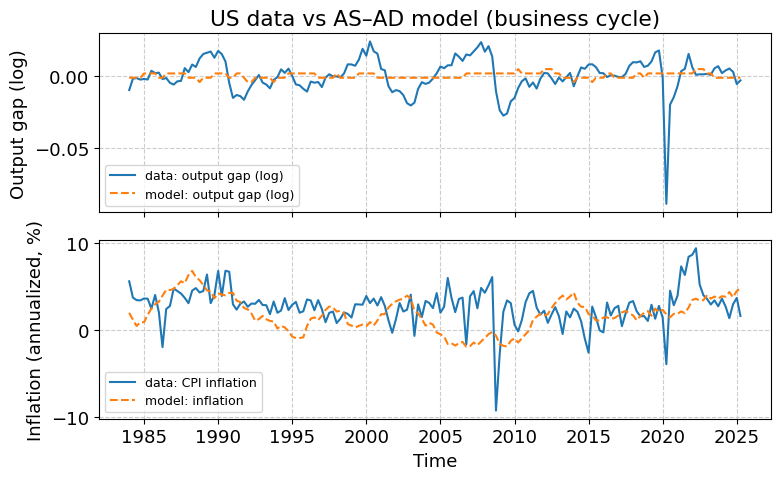

In [68]:
# 1) Take a clean data sample (1980+)
data = us_80s.dropna(subset=["y_gap", "inflation_cpi_ann"]).copy()
T_data = len(data)
t_idx  = data.index

# 2) Parameters with calibrated shock stds
par_plot = par.copy()
par_plot["sigma_x"] = sigma_x_hat
par_plot["sigma_c"] = sigma_c_hat

# 3) Simulate AS AD model
T_sim  = T_data + 200
burn   = 200
v, s   = make_shocks(T_sim, par_plot, seed=123)

y_sim_full, pi_sim_full = simulate_with_rule_grid(
    a1=par_plot["a1"],
    a2=par_plot["a2"],
    v=v,
    s=s,
    p=par_plot
)

# keep last T_data observations
y_sim  = np.asarray(y_sim_full[-T_data:], dtype=float)
pi_sim = np.asarray(pi_sim_full[-T_data:], dtype=float)

# transformations to match data units
# log output gap
gap_sim_log = np.log(y_sim) - np.log(par_plot["ybar"])
# quarterly inflation (decimal) to annualized percent
infl_sim_ann = 400.0 * pi_sim

# 4) Plot: top panel output gap, bottom panel inflation
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

# Output gap (log)
axes[0].plot(t_idx, data["y_gap"], label="data: output gap (log)")
axes[0].plot(t_idx, gap_sim_log, linestyle="--", label="model: output gap (log)")
axes[0].set_ylabel("Output gap (log)")
axes[0].legend(fontsize="x-small")
axes[0].set_title("US data vs AS–AD model (business cycle)")

# Inflation (annualized %)
axes[1].plot(t_idx, data["inflation_cpi_ann"], label="data: CPI inflation")
axes[1].plot(t_idx, infl_sim_ann, linestyle="--", label="model: inflation")
axes[1].set_ylabel("Inflation (annualized, %)")
axes[1].set_xlabel("Time")
axes[1].legend(fontsize="x-small")

plt.tight_layout()
plt.show()


### 4.4. <a id='toc4_4_'></a>[Discussion](#toc0_)

The simulated volatility and persistence of output, inflation, and the
interest rate differ substantially from the U.S. data.

* Output volatility is often **too low**, because the simple IS curve
  lacks strong demand propagation (no capital, expectations, or sticky prices
  beyond the short-run Phillips curve).
* Inflation persistence is typically **too low**, since the AS curve is static
  rather than forward-looking (no inflation inertia).
* Interest-rate volatility depends mechanically on the Taylor rule;
  it can be matched by changing `a1` (policy response to inflation), but that
  distorts the dynamics elsewhere.

These discrepancies illustrate that the AS–AD model is **qualitative** rather
than quantitative: it captures comovement and policy trade-offs, but not the
actual second-moment properties of U.S. cycles.

To get realistic moments we would need:
- Capital accumulation (for output persistence),
- Forward-looking expectations (for inflation inertia),
- Shock propagation through investment and monetary policy smoothing.


## 5. <a id='toc5_'></a>[Wrap-up](#toc0_)

Across the three parts we always followed the same logic:

1. **Choose parameters** $\theta$.
2. **Run the model** to get simulated outcomes.
3. **Compute moments** from the model.
4. **Compare to data** and adjust $\theta$.

Methods:

- **Calibration (Solow):** use formulas and simple root finding to hit a small number of key targets exactly.
- **Moment matching:** define a loss in terms of many moments and let an optimizer search over parameters.

In future courses you will see more advanced versions, but the **core idea is always the same**: connect a model to data by matching moments.
